<a href="https://colab.research.google.com/github/itberrios/CV_tracking/blob/main/SORT/SORT_inplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SORT**

Simple Online and Real Time Tracking.

This notebook provides an implementation of the [SORT](https://arxiv.org/pdf/1602.00763.pdf) Algorithm. The SORT Algorithm is an online detection based tracking algorithm that follows 3 main steps:
 - Detect
 - Associate
 - Filter   

## Download Data

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip

In [6]:
!jar xf 2011_09_26_drive_0106_sync.zip

## Get YOLOv8

In [62]:
!git clone https://github.com/ultralytics/ultralytics
%cd ultralytics
!pip install -r requirements.txt

In [63]:
%cd ..
!pip install ultralytics

### Base Library Import

### (TEMP) Define helper functions here --> These will go into a script later

In [379]:
def compute_iou(box1, box2):
    """ Obtains Intersection over union (IOU) of 2 bounding boxes
        Inputs are in the form of:
            xmin, ymin, xmax, ymax = box
        """
    x11, y11, x21, y21 = box1
    x12, y12, x22, y22 = box2

    # get box points of intersection
    xi1 = max(x11, x12) # top left
    yi1 = max(y11, y12)
    xi2 = min(x21, x22) # bottom right
    yi2 = min(y21, y22)

    # compute intersectional area
    inter_area = max((xi2 - xi1 + 1), 0) * max((yi2 - yi1 + 1), 0)
    if inter_area == 0:
        return inter_area

    # compute box areas
    box1_area = (x21 - x11 + 1) * (y21 - y11 + 1)
    box2_area = (x22 - x12 + 1) * (y22 - y12 + 1)

    # return iou
    return inter_area / (box1_area + box2_area - inter_area)


def compute_cost(box1, box2, iou_thresh=0.3):
    """ Computes Cost between 2 bounding boxes
        """
    iou_cost = compute_iou(box1, box2)
    if (iou_cost >= iou_thresh):
      return iou_cost
    else:
      return 0


def convert_bbox_to_z(bbox):
    """
    Takes a bounding box in the form [x1,y1,x2,y2] and returns z in the form
      [x,y,s,r] where x,y is the centre of the box and s is the scale/area and r is
      the aspect ratio
    """
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    x = bbox[0] + w/2.
    y = bbox[1] + h/2.
    s = w * h    #scale is just area
    r = w / float(h)
    return np.array([x, y, s, r]).reshape((4, 1))


def convert_x_to_bbox(x,score=None):
    """
    Takes a bounding box in the centre form [x,y,s,r] and returns it in the form
      [x1,y1,x2,y2] where x1,y1 is the top left and x2,y2 is the bottom right
    """
    w = np.sqrt(x[2] * x[3])
    h = x[2] / w
    if(score==None):
        return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.]).reshape((1,4))
    else:
        return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.,score]).reshape((1,5))


In [147]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def associate(old_boxes, new_boxes, thresh=0.3):
    """ Associates old boxes with new boxes
    Inputs:
      old_boxes - old bounding boxes at time t - 1
      new_boxes - new bounding boxes at time t
    Function goal: Define a Hungarian Matrix with IOU as a metric and return, for each box, an id
    Outputs:
      matches - matched track indexes (old , new)
      unmatched_detections - unmatched detection indexes
      unmatched_tracks - unmatched track indexes
    """
    if (len(new_boxes) == 0) and (len(old_boxes) == 0):
        return [], [], []
    elif(len(old_boxes)==0):
        return [], np.arange(0, len(new_boxes)), []
    elif(len(new_boxes)==0):
        return [], [], np.arange(0, len(old_boxes))

    # Define a new cost Matrix nxm with old and new boxes
    cost_matrix = np.zeros((len(old_boxes),len(new_boxes)),dtype=np.float32)

    # Go through boxes and store the IOU value for each box 
    # You can also use the more challenging cost but still use IOU as a reference for convenience (use as a filter only)
    for i,old_box in enumerate(old_boxes):
        for j,new_box in enumerate(new_boxes):
            cost_matrix[i][j] = compute_cost(old_box, new_box)
    
    # Find optimal assignments with the  Hungarian Algorithm
    hungarian_row, hungarian_col = linear_sum_assignment(-cost_matrix)
    hungarian_matrix = np.array(list(zip(hungarian_row, hungarian_col)))

    # Create new unmatched lists for old and new boxes
    matches, unmatched_detections, unmatched_tracks = [], [], []

    # Go through the Hungarian Matrix, if matched element has IOU < threshold (0.3), add it to the unmatched 
    # Else: add the match    
    for h in hungarian_matrix:
        if(cost_matrix[h[0],h[1]]<thresh):
            # unmatched_tracks.append(old_boxes[h[0]])
            # unmatched_detections.append(new_boxes[h[1]])
            unmatched_tracks.append(h[0])
            unmatched_detections.append(h[1])
        else:
            matches.append(h.reshape(1,2))
    
    if(len(matches)==0):
        matches = np.empty((0,2),dtype=int)
    else:
        matches = np.concatenate(matches,axis=0)
    
    # Go through old boxes, if no matched detection, add it to the unmatched_old_boxes
    for t, trk in enumerate(old_boxes):
        if(t not in hungarian_matrix[:,0]):
          # unmatched_tracks.append(trk)
          unmatched_tracks.append(t)
    
    # Go through new boxes, if no matched tracking, add it to the unmatched_new_boxes
    for d, det in enumerate(new_boxes):
        if(d not in hungarian_matrix[:,1]):
            # unmatched_detections.append(det)
            unmatched_detections.append(d)
    
    return matches, unmatched_detections, unmatched_tracks

In [388]:
class Obstacle():
    count = 0
    def __init__(self, box, cat):
        ''' 
            box - bounding box ccordinates [x1, y1, x2, y2]
            cat - (int) MSCOCO category
            
            potential adds
            age - track age, number of frames track has been observed
            unmatched_age - number of frames track has not been observed
            fov - (_Bool) flag to denote whether the object is approaching the edge of the FOV
            '''
        self.box = box
        self.cat = cat
        self.age = 0
        self.unmatched_age = 0
        self.fov = 0

        self.id = Obstacle.count
        Obstacle.count += 1

        self.time_since_update = 0
        self.history = []
        self.hits = 1
        self.hit_streak = 0

        # define constant velocity model
        self.kf = KalmanFilter(dim_x=7, dim_z=4) 
        self.kf.F = np.array([[1,0,0,0,1,0,0],[0,1,0,0,0,1,0],[0,0,1,0,0,0,1],[0,0,0,1,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]])
        self.kf.H = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0]])

        self.kf.R[2:,2:] *= 10.
        self.kf.P[4:,4:] *= 1000. #give high uncertainty to the unobservable initial velocities
        self.kf.P *= 10.
        self.kf.Q[-1,-1] *= 0.01
        self.kf.Q[4:,4:] *= 0.01
        # get initial state
        self.kf.x[:4] = convert_bbox_to_z(trk.box)


    def update(self, bbox):
        self.time_since_update = 0
        self.history = []
        self.hits += 1
        self.hit_streak += 1
        # self.box = bbox # in the future use bbox to update Kalman Filter
        self.kf.update(convert_bbox_to_z(bbox))

    def predict(self):
        """
        Advances the state vector and returns the predicted bounding box estimate.
        """
        if((self.kf.x[6]+self.kf.x[2])<=0):
            self.kf.x[6] *= 0.0
        self.kf.predict()
        self.age += 1
        if(self.time_since_update>0):
            self.hit_streak = 0
        self.time_since_update += 1
        self.history.append(convert_x_to_bbox(self.kf.x))
        return self.history[-1]

    def get_state(self):
        """
        Returns the current bounding box estimate.
        """
        return convert_x_to_bbox(self.kf.x)


In [436]:
class Sort():
    def __init__(self, max_age=1, min_hits=1, iou_threshold=0.3):
        self.max_age = max_age
        self.min_hits = min_hits
        self.iou_threshold = iou_threshold
        self.tracks = []
        self.frame_count = 0

        # reset obstacle count
        Obstacle.count = 0

    def update(self, detections=np.empty((0, 5))):
        """ Performs track update
            Inputs:
              detections - array of detections in the form of: [[x1,y1,x2,y2,score],[x1,y1,x2,y2,score],...]
            
            """
        self.frame_count += 1

        # get bounding boxes for currently tracked objects
        old_bboxes = np.array([trk.box for trk in self.tracks])

        # associate boxes to known tracks
        matches, unmatched_detections, unmatched_tracks = \
            associate(old_bboxes, detections[:, :4], thresh=self.iou_threshold)
        
        # update matches
        for m in matches:
            # update box positions
            self.tracks[m[0]].update(detections[m[1], :4])

        # initialize new tracks from unmatched detections
        for d_idx in unmatched_detections:
            box = detections[d_idx][:4]
            cat = detections[d_idx][-1]
            self.tracks.append(Obstacle(box=box, cat=cat))

        # handle unmatched tracks (handle this inside Obstacle)
        for t_idx in unmatched_tracks:
            self.tracks[t_idx].time_since_update += 1
            self.tracks[t_idx].hit_streak = 0

        # manage tracks
        ret = []
        i = len(self.tracks)
        for trk in reversed(self.tracks):
            d = trk.get_state()[0]
            if (trk.time_since_update < 1) and (trk.hit_streak >= self.min_hits or self.frame_count <= self.min_hits):
                ret.append(np.concatenate((d,[trk.id+1])).reshape(1,-1)) # +1 as MOT benchmark requires positive
            i -= 1
            # remove dead tracklet
            if(trk.time_since_update > self.max_age):
                self.tracks.pop(i)
        if(len(ret)>0):
            return np.concatenate(ret)
        return np.empty((0,5))





      

## Base Library Import

In [16]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

## View Data

In [46]:
import os
from glob import glob

data_path = r"/content/2011_09_26/2011_09_26_drive_0106_sync/image_02/data"
frame_paths = sorted(list(glob(os.path.join(data_path, "*.png"))))

In [47]:
# get test frames
frame_idx = 1

frame_1 = cv2.cvtColor(cv2.imread(frame_paths[frame_idx]), cv2.COLOR_BGR2RGB)
frame_2 = cv2.cvtColor(cv2.imread(frame_paths[frame_idx + 1]), cv2.COLOR_BGR2RGB)

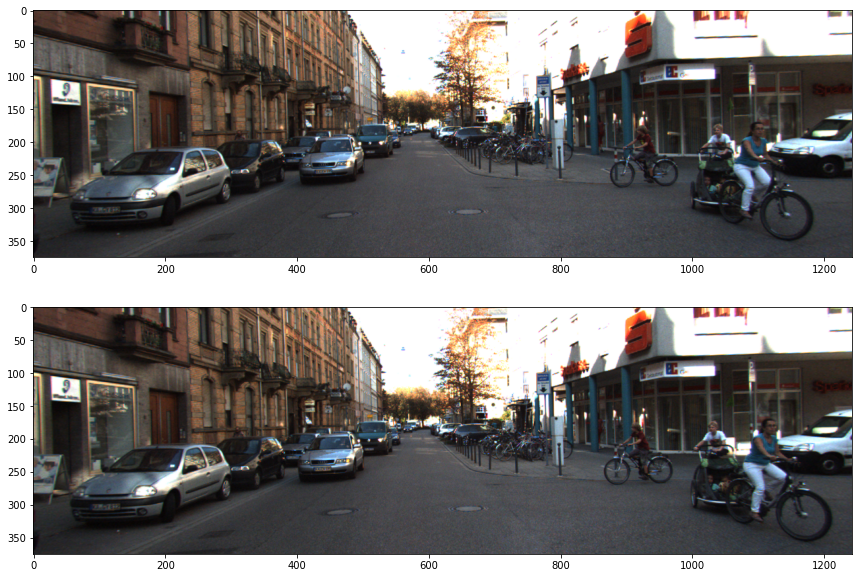

In [61]:
plt.subplot(2, 1, 1)
plt.imshow(frame_1)

plt.subplot(2, 1, 2)
plt.imshow(frame_2)

## Load object Detection model

In [64]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

### Get Color Pallete

In [90]:
from ultralytics.yolo.utils.plotting import Colors

colors = Colors()

Get Detections on frame

In [410]:
def get_detections(model, frame, conf=0.35):
    """ Obtains object detections from a single frame
        Inputs:
            model - YOLOv8 model object
            frame - RGB frame for detection
        Outputs:
            detections - array containing all detections and classes
                [[x1,y1,x2,y2,cls],...]
        NOTE: can modify this to obtain detections for batches of frames
        """
    # can also process multiple frames at once
    results = model(source=frame, stream=True, conf=conf, nms=True, verbose=False)

    for result in results:
        xyxy = result.boxes.xyxy.numpy()
        cls = result.boxes.cls.numpy()

    return np.hstack((xyxy, np.c_[cls])).astype(int)


Get MSCOCO classes

In [236]:
import yaml

coco_fp = r"/content/ultralytics/ultralytics/datasets/coco.yaml"
with open(coco_fp, "r") as stream:
    try:
        coco_info = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# get classes dictionary
classes = coco_info['names']

## Get Colors

In [437]:
def get_color(idx):
    """ Convert an id to a color
    (keep numbers below 255)
    """
    blue = idx*5 % 256
    green = idx*12 %256
    red = idx*23 %256
    return (red, green, blue)

In [438]:
sort = Sort(max_age=3, min_hits=2, iou_threshold=0.3)

result_frames = []
for fpath in frame_paths:
    frame = cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB)
    detections = get_detections(model, frame)

    ret = sort.update(detections)

    # draw track info on frames
    for trk in sort.tracks:
        pt1 = (trk.box[0], trk.box[1])
        pt2 = (trk.box[2], trk.box[3])

        color = get_color(trk.id)
        label = str(classes[int(trk.cat)] + '_' + str(trk.id) + '_' + str(trk.hits))

        frame = cv2.rectangle(frame, pt1, pt2, color, 2)
        frame = cv2.putText(frame, label, (trk.box[0] + 10, trk.box[1] + 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color,thickness=2)

    # save results
    result_frames.append(frame)


## Inspect Results

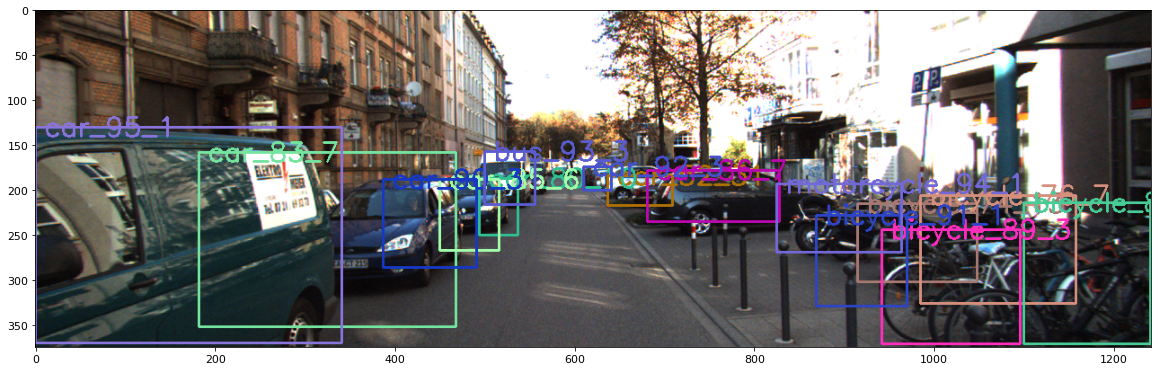

In [439]:
plt.imshow(result_frames[88])

## Make output video

In [441]:
# guestimated form time stamps
fps = 10

out = cv2.VideoWriter('tracked_SORT.mp4',cv2.VideoWriter_fourcc(*'MP4V'), fps, frame.shape[::-1][1:])

for frame in result_frames:
  out.write(frame)

out.release()
     
